# Text Mining Project 1 - Big Bang Theory Script Analysis

*   Amar Music - r0665160
*   Guilherme Consul Soares de Bem - r0917829
*   Sounak Ghosh - r0914328
*   Shinichi Moribe - r0913014

## Importing Libraries and Data

In [1]:
# Import the required libraries
import gdown
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import coo_matrix
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\souna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\souna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\souna\AppData\Roaming\nltk_data...


True

In [2]:
# File ID from the Google Drive link
file_id = '1fkTK1onrBsp2sFUrGTb2f-NGuUyI60PA'

# Output file name
output_file = 'scripts.csv'

# Google Drive download link
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
gdown.download(url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fkTK1onrBsp2sFUrGTb2f-NGuUyI60PA
To: c:\Users\souna\Desktop\Text Mining\Project 1\scripts.csv
100%|██████████| 6.63M/6.63M [00:00<00:00, 13.2MB/s]


'scripts.csv'

---
## Loading the data in a dataframe and filtering to the group character - "Howard"

In [3]:
# Load the dataframe
df = pd.read_csv(output_file, sep=',', skipinitialspace=True, encoding='utf-8')
df.head()

,episode_name,dialogue,person_scene
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Scene
1,Series 01 Episode 01 – Pilot Episode,So if a photon is directed through a plane wi...,Sheldon
2,Series 01 Episode 01 – Pilot Episode,"Agreed, what’s your point?",Leonard
3,Series 01 Episode 01 – Pilot Episode,"There’s no point, I just think it’s a good id...",Sheldon
4,Series 01 Episode 01 – Pilot Episode,Excuse me?,Leonard


In [4]:
# Generating season and episode nr
df['season'] = df['episode_name'].str.extract(r'Series (\d+)').astype(int)
df['episode'] =df['episode_name'].str.extract(r'Episode (\d+)').astype(int)
df = df.drop(['episode_name'], axis=1)

In [5]:
# Filter for our character -> Howard
df = df[df['person_scene'] == 'Howard']
df.head()

,dialogue,person_scene,season,episode
197,Wait till you see this.,Howard,1,1
200,It’s a Stephen Hawking lecture from MIT in 1974.,Howard,1,1
202,It’s before he became a creepy computer voice:.,Howard,1,1
207,"Yeah, right, your grandmother back in town?",Howard,1,1
209,"Hang on, there really is a lady here?",Howard,1,1


In [6]:
# Checking for missing values
df.isnull().sum()

dialogue        0
person_scene    0
season          0
episode         0
dtype: int64

In this section we filtered the dataframe to contain only scripts of Howard, created columns for episode and season numbers, and checked for missing values.

---
## QUESTION 1:
*On average, how many sentences and words does your character have to speak per
episode? Does this deviate across seasons?*

In [7]:
#Keeping the original dialogue
df['original_dialogue'] = df['dialogue']

# Removing the punctuations and lower-casing the text
def preprocess_text(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.replace('’', "'") # Special apostrophe
    text = text.lower()
    return text

df['dialogue'] = df['dialogue'].apply(preprocess_text)

In [8]:
# sentence and word tokenization

# Word Tokenization
df['word_tokens'] = df['dialogue'].apply(lambda x: word_tokenize(x))
df['num_word_tokens'] = df['word_tokens'].apply(lambda x: len(x))

# Sentence Tokenization
df['sentence_tokens'] = df['original_dialogue'].apply(lambda x: sent_tokenize(x))
df['num_sentence_tokens'] = df['sentence_tokens'].apply(lambda x: len(x))

In [9]:
# Group by "season" and "episode" and the total word count and sentence count for Howard
df_group_ep = df.groupby(['season', 'episode']).agg({'num_word_tokens': 'sum', 'num_sentence_tokens': 'sum'})
df_group_ep

num_word_tokens  num_sentence_tokens
season episode                                      
1      1                    197                   24
       2                    195                   25
       3                    290                   36
       4                     46                    9
       5                    121                   13
...                         ...                  ...
10     20                   436                   52
       21                   296                   44
       22                   349                   44
       23                   243                   32
       24                   133                   20

[231 rows x 2 columns]

In [10]:
# Average words and sentences spoken per episode in every season
df_avg_season = df_group_ep.groupby(['season']).agg({'num_word_tokens':'mean', 'num_sentence_tokens':'mean'})
df_avg_season

,num_word_tokens,num_sentence_tokens
season,,
1,278.411765,32.235294
2,306.434783,38.130435
3,314.521739,42.521739
4,270.916667,40.500000
5,301.625000,40.208333
6,332.375000,46.875000
7,277.541667,37.791667
8,303.541667,40.000000
9,273.291667,37.875000


In [11]:
# Statistics on the number of words and sentences spoken per episode across seasons
df_group_ep.describe()

,num_word_tokens,num_sentence_tokens
count,231.000000,231.000000
mean,292.307359,39.363636
std,151.831216,19.977319
min,11.000000,2.000000
25%,182.000000,24.000000
50%,273.000000,36.000000
75%,385.000000,51.000000
max,732.000000,103.000000


As can be seen on the statistics per season and global, the average number of words and sentences spoken by Howard does not deviate a lot across seasons. This can be further observed in the barplots below.

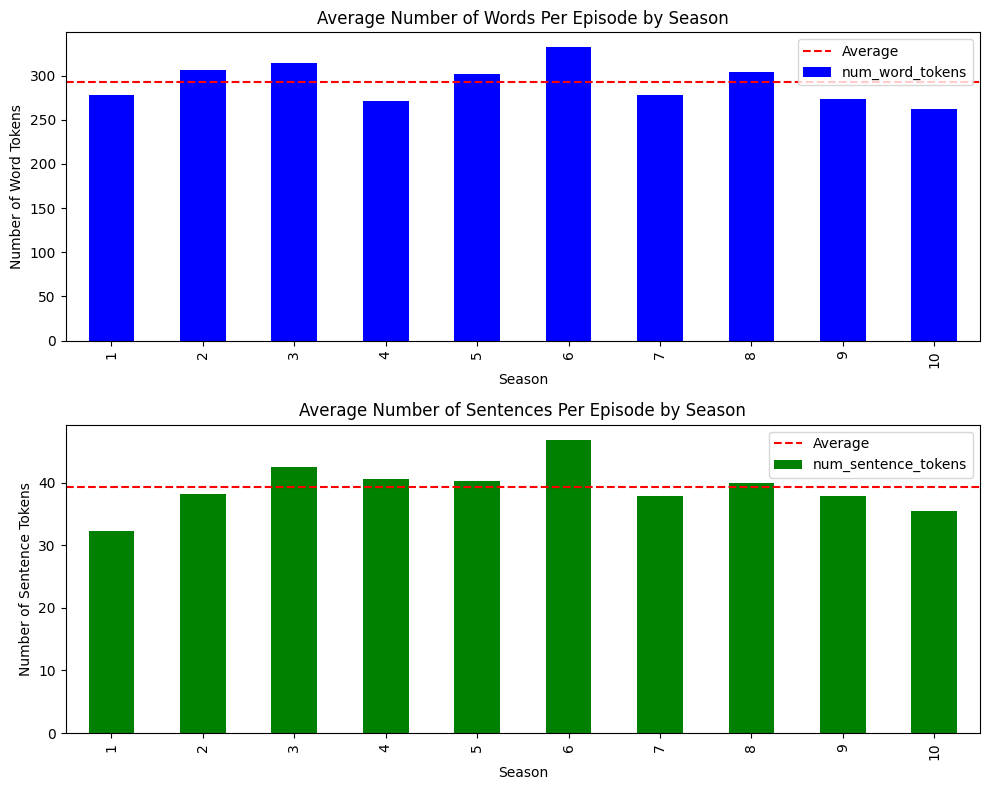

In [12]:
# Plot the average number of words and sentences per episode in all seasons

# Calculate average values
avg_word_tokens = df_group_ep['num_word_tokens'].mean()
avg_sentence_tokens = df_group_ep['num_sentence_tokens'].mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
# Bar plot for num_word_tokens
df_avg_season['num_word_tokens'].plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Average Number of Words Per Episode by Season')
axes[0].set_ylabel('Number of Word Tokens')
axes[0].set_xlabel('Season')
# Add a dashed line for the average
axes[0].axhline(y=avg_word_tokens, color='red', linestyle='--', label='Average')

# Bar plot for num_sentence_tokens
df_avg_season['num_sentence_tokens'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Average Number of Sentences Per Episode by Season')
axes[1].set_ylabel('Number of Sentence Tokens')
axes[1].set_xlabel('Season')
# Add a dashed line for the average
axes[1].axhline(y=avg_sentence_tokens, color='red', linestyle='--', label='Average')

# Show legend
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

The dashed red line represents the global averages of number of words and sentences spoken per episode. A strong deviation between seasons is not observed.

---
# QUESTION 2:
*Globally, over all episodes within the first 10 seasons, how many times does your
character mention nouns, and person names? Make a Wordcloud of this tag/entity to
have a clear visualization which nouns/person names are mostly used by your character.*

In [13]:
# Function to extract nouns and person names from a text using POS tagging
nlp = spacy.load("en_core_web_sm")
def extract_entity(text, entity_name):
    doc = nlp(text)
    entities = [token.text for token in doc if token.pos_ == entity_name]
    return entities

# Applying the function on the dataset to generate the nouns and persons list
nouns = df['dialogue'].apply(extract_entity, entity_name='NOUN')
persons = df['dialogue'].apply(extract_entity, entity_name='PROPN')

In [14]:
joined_nouns = [item for sublist in nouns for item in sublist]
joined_persons = [item for sublist in persons for item in sublist]

print(f"Times Howard mention NOUNS in all seasons: {len(joined_nouns)}")
print(f"Times Howard mention PERSONS in all seasons: {len(joined_persons)}")

Times Howard mention NOUNS in all seasons: 10170
Times Howard mention PERSONS in all seasons: 1279


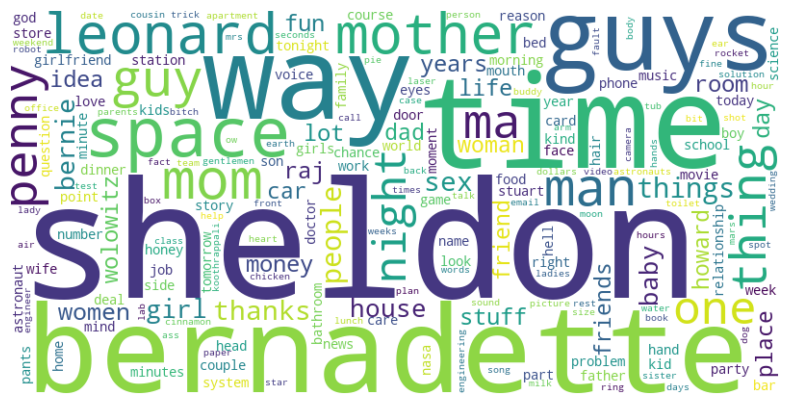

In [15]:
# Count the occurrences of each entity
entity_counts = Counter(joined_nouns+joined_persons)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_counts)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Howard mention NOUNS 10170 times and PERSONS 1279 times. The word cloud shows the most spoken words between nouns and persons.

---
## QUESTION 3:

*What are the most important words mentioned by your character? Do this analysis
per episode, per season and overall over the first 10 seasons. To achieve this task,
please first make a bag-of-words and/or use the TF-IDF statistical principle. Remark:
You can try to make a Wordcloud for visualization, based on the given bag-of-words.*

### TF-IDF Approach

In [16]:
# Modifying the preprocessing function for removal of stopwords
def preprocess_text_further(text):
    # Remove NLTK stopwords
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)

    # Instantiate lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    text = ' '.join([word for word in tokens if word.lower() not in stop_words])

    # POS-tagging
    doc = nlp(text)
    text = ' '.join([token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV']])

    return text

def top_indices(matrix, n=3):
    # Get the indices of the top n values in each row
    top_indices_per_row = np.argsort(matrix, axis=1)[:, -n:][:, ::-1]

    return top_indices_per_row

The preprocessing function here is used to filter the scripts a bit further in order to obtain more meaninful results when using the TF-IDF algorithm. In this function, we are applying lemmatization to reduce words to their base or dictionary form (lemma). Unlike stemming, lemmatization considers the context and ensures that the resulting word is a valid word. We are also removing stop words and only keeping words with specific POS tagging (listed above) to remove words that do not convey significance when extracting important words in a text.

In [17]:
# Combine dialogues per episode for TF-IDF analysis
episodes_dialogues = df.groupby(['season', 'episode'])['dialogue'].apply(' '.join).reset_index()

# Combine dialogues per episode for TF-IDF analysis
season_dialogues = df.groupby(['season'])['dialogue'].apply(' '.join).reset_index()

# Combine all dialogues
all_dialogues = df['dialogue'].str.cat()

- Most important words per episode (TF-IDF Approach)

In [18]:
# Initialize TF-IDF vectorizer with NLTK stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the dialogues after preprocessing for every episode
tfidf_matrix_ep = tfidf_vectorizer.fit_transform(episodes_dialogues['dialogue'].apply(preprocess_text_further))

# Get feature names (words) from the TF-IDF vectorizer
feature_names_ep_tfidf = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame
tfidf_df_ep = pd.DataFrame(tfidf_matrix_ep.toarray(), columns=feature_names_ep_tfidf)

# Get the top 5 words based on average TF-IDF scores
top_words_indices_ep_tfidf = top_indices(tfidf_df_ep.values, 5)
top_words_ep_tfidf = [[feature_names_ep_tfidf[j] for j in i] for i in top_words_indices_ep_tfidf]
top_words_ep_tfidf

[['coitus', 'quest', 'photograph', 'jupiter', 'karaoke'],
 ['puffy', 'hug', 'russian', 'problem', 'yard'],
 ['gate', 'human', 'slash', 'robot', 'sheldon'],
 ['bold', 'summer', 'special', 'bitch', 'arm'],
 ['music', 'union', 'stud', 'cardiofunk', 'beauty'],
 ['shrug', 'boygirl', 'party', 'peter', 'brush'],
 ['medpack', 'loofah', 'hofstadter', 'wolowitz', 'call'],
 ['parent', 'fiddler', 'indian', 'course', 'premise'],
 ['isp', 'lisbon', 'lamp', 'francisco', 'halifax'],
 ['farminfarmian', 'millenium', 'symposium', 'chewbacca', 'falcon'],
 ['sensor', 'angle', 'true', 'sheldon', 'ape'],
 ['biology', 'payload', 'smart', 'sheldon', 'kid'],
 ['team', 'perpetual', 'spock', 'squad', 'motion'],
 ['bell', 'machine', 'telephone', 'dibs', 'time'],
 ['handkerchief', 'missy', 'destiny', 'cane', 'hallelujah'],
 ['birthday', 'ha', 'peanut', 'definitive', 'granola'],
 ['tangerine', 'movement', 'blog', 'hand', 'chicken'],
 ['sake', 'date', 'sleep', 'bed', 'hot'],
 ['slave', 'bosom', 'girl', 'renaissance',

The lists above contain the top 5 most important words per episode according to their TD-IDF scores. Upon visual inspection it seems like the top words are a good representation of each episode.

- Most important words per season (TF-IDF Approach)

In [19]:
# Fit and transform the dialogues after preprocessing for every season
tfidf_matrix_season = tfidf_vectorizer.fit_transform(season_dialogues['dialogue'].apply(preprocess_text_further))

# Get feature names (words) from the TF-IDF vectorizer
feature_names_season_tfidf = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame
tfidf_df_season = pd.DataFrame(tfidf_matrix_season.toarray(), columns=feature_names_season_tfidf)

# Get the top 3 words based on average TF-IDF scores
top_words_indices_season_tfidf = top_indices(tfidf_df_season.values, 5)
top_words_season_tfidf = [[feature_names_season_tfidf[j] for j in i] for i in top_words_indices_season_tfidf]
top_words_season_tfidf

[['sheldon', 'leonard', 'time', 'back', 'right'],
 ['sheldon', 'leonard', 'little', 'woman', 'leslie'],
 ['bernadette', 'right', 'sheldon', 'girlfriend', 'goth'],
 ['bernadette', 'sheldon', 'mother', 'right', 'doe'],
 ['really', 'bernadette', 'guy', 'right', 'well'],
 ['space', 'really', 'guy', 'right', 'sheldon'],
 ['bernadette', 'guy', 'really', 'well', 'mom'],
 ['right', 'well', 'mother', 'emily', 'doe'],
 ['really', 'guy', 'guidance', 'right', 'well'],
 ['maybe', 'baby', 'right', 'halley', 'great']]

The lists above contain the top 5 most important words per season according to their TD-IDF scores. The season lists are more general than the episodes list, which makes sense considering the number of "documents" in the TF-IDF calculation is much smaller.

- Most important words for all seasons (TF-IDF)

In [20]:
# Fit and transform the dialogues after preprocessing for every season
full_text_preprocessed = preprocess_text_further(all_dialogues)
tfidf_matrix_all = tfidf_vectorizer.fit_transform([full_text_preprocessed])

# Get feature names (words) from the TF-IDF vectorizer
feature_names_all_tfidf = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame
tfidf_df_all = pd.DataFrame(tfidf_matrix_all.toarray(), columns=feature_names_all_tfidf)

# Get the top 3 words based on average TF-IDF scores
top_words_indices_all_tfidf = top_indices(tfidf_df_all.values, 5)
top_words_all_tfidf = [[feature_names_all_tfidf[j] for j in i] for i in top_words_indices_all_tfidf]
top_words_all_tfidf

[['right', 'sheldon', 'guy', 'little', 'well']]

This results should be just the top 5 most frequent words in the full scripts, since there is only one "document" for TF-IDF to consider.

In [21]:
string_counts = Counter(full_text_preprocessed.split(' '))
# Sort by descending order of counts
sorted_counts = sorted(string_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 5
print("Top 5 occurrences:")
for item in sorted_counts[:5]:
    print(f"{item[0]}: {item[1]}")

Top 5 occurrences:
right: 174
sheldon: 156
guy: 149
little: 142
well: 136


As can be seen, these are the most important words in all howard's scripts combined, considering the preprocessing steps performed.

### BoW Approach
We now use the bag of words (BoW) approach to answer the same questions as before. Our reasoning for this is that since we're working with a format that works with episodes that each have their own story/themes, this might impact the output in TF-IDF as the total frequency may be affected by specific episodes where some words appear many times but never again.


Most important per episode (BoW Approach)

In [22]:
#bow-vectorizer
bow_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

In [23]:
# Episodes
episodes_bow_matrix = bow_vectorizer.fit_transform(episodes_dialogues['dialogue'].apply(preprocess_text_further))

# Get feature names (words) from the BOW vectorizer
feature_names_ep_bow = bow_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame
bow_df_ep = pd.DataFrame(episodes_bow_matrix.toarray(), columns=feature_names_ep_bow)

# Get the top 3 words based on average TF-IDF scores
top_words_indices_ep_bow = top_indices(bow_df_ep.values, 5)
top_words_ep_bow = [[feature_names_ep_bow[j] for j in i] for i in top_words_indices_ep_bow]
top_words_ep_bow

[['coitus', 'back', 'quest', 'work', 'woman'],
 ['puffy', 'hug', 'maybe', 'problem', 'little'],
 ['sheldon', 'gate', 'human', 'leonard', 'ever'],
 ['bold', 'arm', 'excuse', 'wolowitz', 'lady'],
 ['music', 'union', 'beatbox', 'cardiofunk', 'godzilla'],
 ['party', 'hair', 'peter', 'shrug', 'boygirl'],
 ['night', 'last', 'medpack', 'loofah', 'wolowitz'],
 ['parent', 'indian', 'time', 'course', 'fine'],
 ['san', 'lisbon', 'francisco', 'mouse', 'isp'],
 ['leia', 'princess', 'trip', 'wait', 'farminfarmian'],
 ['sheldon', 'true', 'right', 'leonard', 'sensor'],
 ['sheldon', 'thing', 'space', 'kid', 'payload'],
 ['team', 'sheldon', 'night', 'answer', 'motion'],
 ['time', 'machine', 'bell', 'friend', 'dibs'],
 ['handkerchief', 'howard', 'destiny', 'missy', 'girl'],
 ['birthday', 'fine', 'friend', 'peanut', 'way'],
 ['hand', 'tangerine', 'movement', 'right', 'chicken'],
 ['god', 'sleep', 'bed', 'mom', 'leonard'],
 ['girl', 'sheldon', 'penny', 'slave', 'bosom'],
 ['probably', 'different', 'way', '

As expected, the results largely correspond with the ones from TF-IDF.

In [24]:
# Seasons
season_bow_matrix = bow_vectorizer.fit_transform(season_dialogues['dialogue'].apply(preprocess_text_further))

# Get feature names (words) from the BOW vectorizer
feature_names_season_bow = bow_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame
bow_df_season = pd.DataFrame(season_bow_matrix.toarray(), columns=feature_names_season_bow)

# Get the top 3 words based on average TF-IDF scores
top_words_indices_season_bow = top_indices(bow_df_season.values, 5)
top_words_season_bow = [[feature_names_season_bow[j] for j in i] for i in top_words_indices_season_bow]
top_words_season_bow

[['sheldon', 'leonard', 'time', 'back', 'right'],
 ['sheldon', 'leonard', 'little', 'woman', 'penny'],
 ['right', 'bernadette', 'sheldon', 'leonard', 'little'],
 ['sheldon', 'bernadette', 'mother', 'right', 'doe'],
 ['really', 'right', 'guy', 'bernadette', 'well'],
 ['space', 'really', 'guy', 'little', 'right'],
 ['guy', 'mom', 'really', 'well', 'little'],
 ['right', 'well', 'mother', 'doe', 'thing'],
 ['really', 'guy', 'right', 'well', 'thing'],
 ['maybe', 'right', 'baby', 'great', 'well']]

In [25]:
# All seasons ensemble
all_bow_matrix = bow_vectorizer.transform([full_text_preprocessed])

# Get feature names (words) from the BOW vectorizer
feature_names_all_bow = bow_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame
bow_df_all = pd.DataFrame(all_bow_matrix.toarray(), columns=feature_names_all_bow)

# Get the top 3 words based on average TF-IDF scores
top_words_indices_all_bow = top_indices(bow_df_all.values, 5)
top_words_all_bow = [[feature_names_all_bow[j] for j in i] for i in top_words_indices_all_bow]
top_words_all_bow

[['right', 'sheldon', 'guy', 'little', 'well']]

Finally, for the full document, the results are exactly the same for BoW and TF-IDF.

---
## QUESTION 4:

*Examine the co-occurence of words for your character by using the Positive Pointwise Mutual Information measurement. Which words are commonly used together in
his/her dialogues? Remark: You can try to make a Word-Word co-occurence matrix*

#### Define functions for co-occurrence matrix, PPMI, extracting words with high PPMIs (The word-word co-occurrence matrix function doesn't consider the order of two words, as shown on lecture slide p.141.)

In [26]:
# Define a function that creates the co-occurrence matrix
def co_occurrence_matrix(documents):

    # add StartofSentence and EndofSentence to the beginning and end of each sentence
    sentences = ['startofsentence ' + sentence + ' endofsentence' for sentence in documents]
    sentences = ' '.join(sentences) # join all sentences into one string

    translator = str.maketrans('', '', string.punctuation)
    sentences = sentences.translate(translator)
    sentences= sentences.replace('’', "'") # Special apostrophe
    sentences = sentences.lower()

    # Tokenize the text
    tokens = word_tokenize(sentences)

    # Define the context window size
    window_size = 1

    # Create a defaultdict to store co-occurrences
    co_occurrence = defaultdict(lambda: defaultdict(int))

    # Populate the co-occurrence matrix
    for i in range(len(tokens)):
        word = tokens[i]
        if word not in stopwords.words('english'):  # Exclude common stopwords
            for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
                if i != j and tokens[j] not in stopwords.words('english'):  # Exclude common stopwords and self-co-occurrence
                    co_occurrence[word][tokens[j]] += 1

    # Initialize a vocabulary list
    vocab = list(co_occurrence.keys())

    # Initialize the co-occurrence matrix
    matrix = np.zeros((len(vocab), len(vocab)))

    # Fill in the matrix values based on co-occurrence counts
    for i, word1 in enumerate(vocab):
        for j, word2 in enumerate(vocab):
            matrix[i][j] = co_occurrence[word1][word2]

    # Make co-occurrence of "StartofSentence" and "EndofSentence" zero
    StartofSentence_index = vocab.index('startofsentence')
    EndofSentence_index = vocab.index('endofsentence')
    matrix[StartofSentence_index, EndofSentence_index] = 0
    matrix[EndofSentence_index, StartofSentence_index] = 0
    # Delete "StartofSentence" and "EndofSentence" if they don't co-occur with any other words
    if np.sum(matrix[StartofSentence_index, :]) == 0:
        matrix = np.delete(matrix, StartofSentence_index, axis=0)
        matrix = np.delete(matrix, StartofSentence_index, axis=1)
        vocab.remove('startofsentence')
    if np.sum(matrix[EndofSentence_index, :]) == 0:
        matrix = np.delete(matrix, EndofSentence_index, axis=0)
        matrix = np.delete(matrix, EndofSentence_index, axis=1)
        vocab.remove('endofsentence')

    return matrix, vocab



def PPMI(matrix):
    # Get the total sum of the matrix
    total_sum = np.sum(matrix)/2
    joint_prob = matrix / total_sum

    # Calculate the row and column sums
    row_sum = np.sum(matrix, axis=1)
    col_sum = np.sum(matrix, axis=0)

    # Calculate the probabilities
    row_prob = row_sum / total_sum
    col_prob = col_sum / total_sum

    # the prodct of probalities of each word
    pro_prob = np.outer(row_prob, col_prob)

    # Calculate the PPMI matrix
    ppmi_matrix = np.maximum(np.log(joint_prob/pro_prob), 0)

    return ppmi_matrix



def top_n_co_octurrence(ppmi,vocab, n=1):
    # Get the indices of the top n*2 values since the matrix is symmetric
    flattened_indices = np.argsort(-ppmi , axis=None)[:n*2]
    # Get the row and column indices of the top n*2 values
    top_n_indices = np.unravel_index(flattened_indices, ppmi.shape)

    for i in range(n*2):
        if top_n_indices[0][i] < top_n_indices[1][i]:
            print(vocab[top_n_indices[0][i]]+'-'+vocab[top_n_indices[1][i]])
    return


* The function "*co_occurence_matrix*" processes a list of documents by adding
sentence markers, removing punctuation, converting to lowercase, and tokenizing. It then creates a co-occurrence matrix to capture word associations within a defined context window, excluding common English stopwords. The function returns the co-occurrence matrix and a corresponding vocabulary list.

* While the function "PPMI" processes a co-occurrence matrix by computing joint probabilities, row and column sums, and individual word probabilities. It then calculates a Pointwise Mutual Information (PMI) matrix and transforms it into a Positive PMI (PPMI) matrix. The resulting PPMI matrix is returned.

In [27]:
matrix, vocab=co_occurrence_matrix(df['original_dialogue'])
ppmi = PPMI(matrix)
top_n_co_octurrence(ppmi, vocab, n=20)

enormous-amount
gifted-programme
discernible-pattern
william-shatner
armed-goblins
rolling-stone
barbershop-quartet
vampires-shave
satanic-fungus
november-16
dusty-highway
whiplash-collar
respectful-manner
dandruff-medication
gate-guarding
seating-charts
delicately-suggests
topical-conferences
pictographic-representation
brutal-dismemberment
chunky-bridesmaids


These pairs of words have 20 highest PPMI. These words are not used in the dialogue frequently, but when they are used, they usually are used together. From the selection of less frequently used words, we can see the limitations of PPMI.